<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Simple Linear Regression with Sacramento Real Estate Data

_Authors: Matt Brems, Sam Stack, Justin Pounders_

---

In this lab you will hone your exploratory data analysis (EDA) skills and practice constructing simple linear regressions using a data set on Sacramento real estate sales.  The data set contains information on qualities of the property, location of the property, and time of sale.

### 1. Read in the Sacramento housing data set.

In [63]:
sac_csv = './datasets/sacramento_real_estate_transactions.csv'

In [126]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 

### 2. Conduct exploratory data analysis on this data set. 

**Report any notable findings here and any steps you take to clean/process data.**

> **Note:** These EDA checks should be done on every data set you handle. If you find yourself checking repeatedly for missing/corrupted data, it might be beneficial to have a function that you can reuse every time you're given new data.

In [ ]:
sac = pd.read_csv(sac_csv)
sac.head(3)

#### Check Nulls

In [ ]:
#Let's check for null values first and foremost
sac.isnull().sum()

In [ ]:
#Let's get a feel for the data types we're working with
sac.dtypes

In [ ]:
#Check for nulls in one more way to make sure we don't pick any up
sac.isnull().any()

#### Check Type

In [ ]:
# Break out our data by type. It appears we have one straggling row with value 'Unkown'
sac.type.value_counts()

In [ ]:
#Drop this from out data set
sac = sac[sac['type'] != 'Unkown']

In [ ]:
#confirm that it's now gone from our DF
sac.type.value_counts()

There seems to be no information here to guide us as to what type of apartment this is (sq__ft would have been best indicator based on domain knowledge. So we'll drop this from our df.

#### Check Bed/Baths

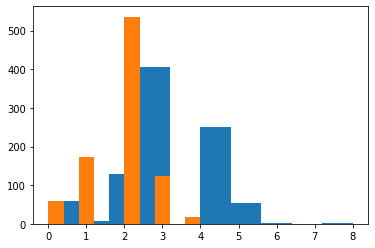

In [65]:
#Plot distributions of beds and baths -- any significant outliers or negative values we need to know of?
plt.hist(sac.beds);
plt.hist(sac.baths);

#### Dropping Negative Prices

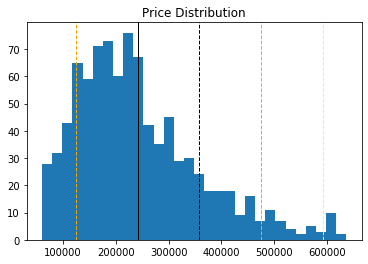

In [66]:
#Checking price for any unexpected values. It appears we have some negative and near-zero figures we'll have to address
ax = plt.hist(sac.price, bins = 30);
plt.axvline(sac['price'].mean() - sac['price'].std(), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(sac['price'].mean(), color='black', linewidth=1)
plt.axvline(sac['price'].mean() + sac['price'].std(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(sac['price'].mean() + 2*sac['price'].std(), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(sac['price'].mean() + 3*sac['price'].std(), color='yellow', linestyle='dashed', linewidth=1);
plt.title('Price Distribution');

In [67]:
#drop negative or zero price homes
sac = sac[sac['price'] > 0]

#### Check into Remaining Low Cost Homes

In [68]:
#We have a large count of homes in Crystalwood Circle which appear to have a set low value. 
#Outside research indicates these values are well below teh expected median value price ofa home in 2008
sac.loc[(sac['price'] == 4897),'street'].value_counts()

Series([], Name: street, dtype: int64)

Let's zoom in on lower house values beyond 1 standard deviation...

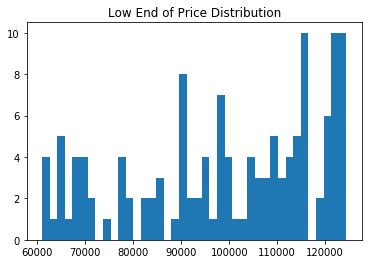

In [69]:
plt.hist(sac.loc[sac['price'] < (sac['price'].mean() - sac['price'].std()),:].price, bins = 40);
plt.title('Low End of Price Distribution');

It looks like there are some stragglers under 60k. We also see a significant number of homes near zero, which represent our Circlewood homes we identified earlier. Because the gap is so large, I think we can remove these from out dataset.

In [70]:
sac = sac.loc[(sac['price'] > 60000),:]

Now let's take a look at the top end of our distribution. Recall...

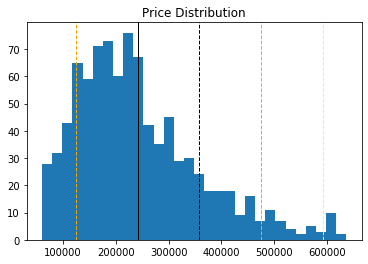

In [71]:
sac = sac[sac['price'] >= 0]

ax = plt.hist(sac.price, bins = 30);
plt.axvline(sac['price'].mean() - sac['price'].std(), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(sac['price'].mean(), color='black', linewidth=1)
plt.axvline(sac['price'].mean() + sac['price'].std(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(sac['price'].mean() + 2*sac['price'].std(), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(sac['price'].mean() + 3*sac['price'].std(), color='yellow', linestyle='dashed', linewidth=1);
plt.title('Price Distribution');

Let's zoom in on everything beyond 1 standard deviation higher than the mean.

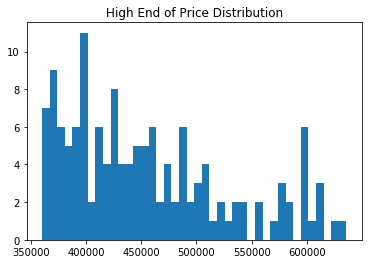

In [72]:
#Zoom in on high end of our distribution to see if there are any visual discrepanices
plt.hist(sac.loc[sac['price'] > (sac['price'].mean() + sac['price'].std()),:].price, bins = 40);
plt.title('High End of Price Distribution');

the Volume of homes within the 40-55K range seem to follow a consistent desscending pattern. At 60K, we see an uptick, at which point we also see some observations scattered at higher price points. Let's look at this in the table to see if we can glean any more insight.

In [73]:
sac[sac['price'] > 600000].head(3)

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,Condo,Multi-Family,Residential
155,4070 REDONDO DR,EL DORADO HILLS,95762,CA,4,3,2356.0,Residential,2008-05-21,606238,38.666807,-121.064830,0,0,1
330,2981 WRINGER DR,ROSEVILLE,95661,CA,4,3,3838.0,Residential,2008-05-20,613401,38.735373,-121.227072,0,0,1
331,8616 ROCKPORTE CT,ROSEVILLE,95747,CA,4,2,3838.0,Residential,2008-05-20,614000,38.742118,-121.359909,0,0,1


There doesn't appear to be any consistent pattern across these homes. However, because they are so far from our mean (3+ StdDevs), I feel comfortable removing them.

In [74]:
sac = sac[sac['price'] < (sac['price'].mean() + 3*sac['price'].std())]

#### Check Cities

In [75]:
#A quick value_count() by City doesn't reveal any issues, these all appear to be a part of Sacramento County
sac.city.value_counts()

SACRAMENTO         428
ELK GROVE          114
ROSEVILLE           44
CITRUS HEIGHTS      33
ANTELOPE            33
RANCHO CORDOVA      28
LINCOLN             22
NORTH HIGHLANDS     21
GALT                21
CARMICHAEL          19
EL DORADO HILLS     17
FOLSOM              16
ROCKLIN             15
RIO LINDA           12
ORANGEVALE          11
PLACERVILLE          9
CAMERON PARK         9
FAIR OAKS            8
AUBURN               5
GOLD RIVER           4
ELVERTA              4
WILTON               3
POLLOCK PINES        3
RANCHO MURIETA       3
WEST SACRAMENTO      3
EL DORADO            2
GREENWOOD            1
GARDEN VALLEY        1
COOL                 1
MEADOW VISTA         1
LOOMIS               1
PENRYN               1
FORESTHILL           1
MATHER               1
WALNUT GROVE         1
DIAMOND SPRINGS      1
Name: city, dtype: int64

#### Find Duplicates

In [76]:
#Filter df for repeating rows
sac[sac.duplicated()]

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,Condo,Multi-Family,Residential


In [77]:
#Drop repeating rows
sac = sac.drop_duplicates()

In [78]:
#Make sure that we were effective in dropping duplicated by summing results of duplicated()
sac[sac.duplicated()].sum().sum()

0.0

#### Check State and Longitudes

In [79]:
#Does the State column have anything else beyond CA?
sac.state.value_counts()

CA    897
Name: state, dtype: int64

In [80]:
#Ensure that 'AC' is dropped
sac = sac[sac['state'] == 'CA']

In [81]:
#Validate that this dropped out of our data set
sac.state.value_counts()

CA    897
Name: state, dtype: int64

In [82]:
#We know the lat/long for sacramento is roughly:
#LAT: ~38-39 Deg
#Long: 121 Deg
sac.describe().T.loc[['latitude','longitude'],['count', 'mean', 'min', 'max']]

,count,mean,min,max
latitude,897.0,38.590501,38.241514,39.020808
longitude,897.0,-121.364396,-121.551704,-120.597599


#### Check Zips

In [83]:
#Check that all zipcodes appear consistent
sac['zip'].unique()

array([95823, 95815, 95824, 95841, 95842, 95820, 95670, 95673, 95838,
       95822, 95621, 95833, 95660, 95834, 95843, 95832, 95827, 95828,
       95758, 95626, 95825, 95835, 95624, 95632, 95826, 95608, 95662,
       95630, 95829, 95655, 95757, 95742, 95726, 95818, 95762, 95831,
       95683, 95693, 95814, 95635, 95817, 95864, 95628, 95682, 95648,
       95667, 95610, 95722, 95816, 95678, 95747, 95819, 95811, 95677,
       95765, 95603, 95821, 95661, 95623, 95663, 95631, 95619, 95650,
       95614, 95690, 95633, 95691], dtype=int64)

Zipcodes appear to be consistent with expectations for Sacramento. Which zipcodes have the highest revenue?

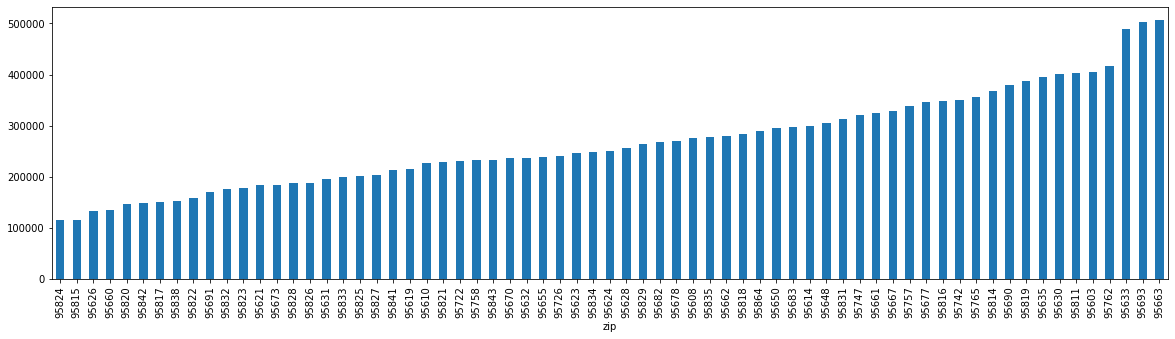

In [84]:
#Do any zipcodes stand out in terms of average price
plt.figure(figsize=(20,5))
sac.groupby('zip')['price'].apply(np.mean).sort_values(ascending=True).plot(kind='bar');

#### Convert date column to datetime

In [85]:
#Use to_datetime to cast 'sale_date' so we can more easily create visuals / reference dt object as needed moving forward
sac['sale_date'] = pd.to_datetime(sac['sale_date'] );

In [86]:
#confirm this went through
sac.dtypes

street                  object
city                    object
zip                      int64
state                   object
beds                     int64
baths                    int64
sq__ft                 float64
type                    object
sale_date       datetime64[ns]
price                    int64
latitude               float64
longitude              float64
Condo                    uint8
Multi-Family             uint8
Residential              uint8
dtype: object

#### Check Sq Footage

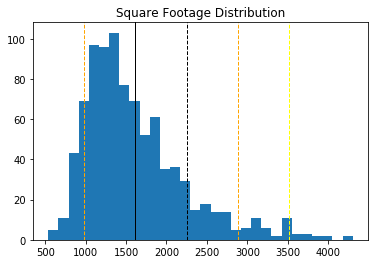

In [87]:
#Let's look at square footage. We'll plot the distribution, mean, and standard deviation lines to get a sense for major outliers.
ax = plt.hist(sac['sq__ft'], bins = 30);
plt.axvline(sac['sq__ft'].mean() - sac['sq__ft'].std(), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(sac['sq__ft'].mean() + sac['sq__ft'].std(), color='black',linestyle='dashed', linewidth=1)
plt.axvline(sac['sq__ft'].mean(), color='k', linewidth=1)
plt.axvline(sac['sq__ft'].mean() + 2*sac['sq__ft'].std(), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(sac['sq__ft'].mean() + 3*sac['sq__ft'].std(), color='yellow', linestyle='dashed', linewidth=1);
plt.title('Square Footage Distribution');

There appears to be a cluster of homes that are near or around zero. We expect sq__ft to be highly correlated with sale price given our knowledge of real estate. How does this translate into a scatter plot?

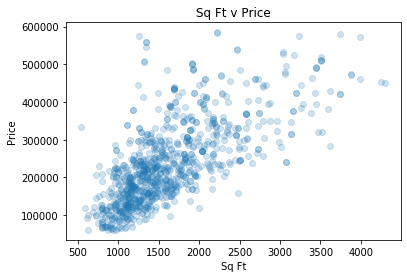

In [88]:
#Scatter plot between square footage and price
plt.scatter(sac['sq__ft'],sac['price'], alpha=0.2);
plt.xlabel('Sq Ft')
plt.ylabel('Price')
plt.title('Sq Ft v Price');

In [89]:
#What percent of our data set does this represent
sac.loc[(sac['sq__ft'] < 300),['sq__ft']].count() / len(sac) * 100

sq__ft    0.0
dtype: float64

This group of zero square footage homes appear to have a variety of prices. In addition to this, these rows represent ~13% of our dataset which is a non-negligible amount. For that reason, and given that this is a clear visual outlier from the existing relationship for the rest of the graph which shows that there is a positive correlation between this feature and price, we will leverage the ffill method which will approximate an appropriate square footage based on price

In [90]:
#Let's drop the zeroes and replace with Nan so we can reference them when filling our values in a smarter war
sac['sq__ft'].replace(0, np.nan, inplace=True)

In [91]:
#Sort our dataset by price, isolate for sq__ft, then fill NANs with ffill method
sac['sq__ft'] = sac.sort_values('price')['sq__ft'].fillna(method='ffill')

In [92]:
sac.isnull().sum()

street          0
city            0
zip             0
state           0
beds            0
baths           0
sq__ft          0
type            0
sale_date       0
price           0
latitude        0
longitude       0
Condo           0
Multi-Family    0
Residential     0
dtype: int64

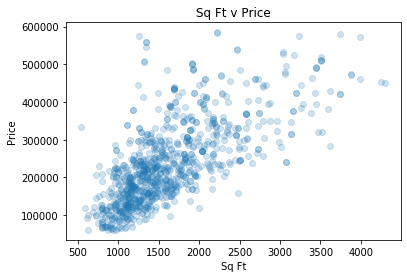

In [93]:
#Check again
plt.scatter(sac['sq__ft'],sac['price'], alpha=0.2);
plt.xlabel('Sq Ft')
plt.ylabel('Price')
plt.title('Sq Ft v Price');

#### Assessing Correlation between Feature/Target, Among Features

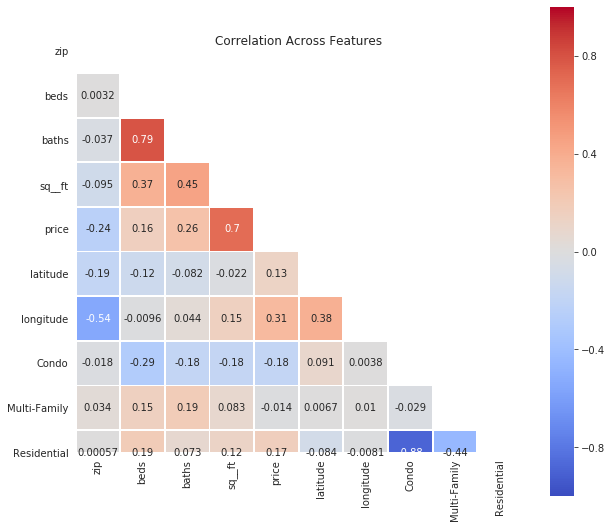

In [94]:
#Build figure space
plt.figure(figsize=(10,9))

#Generate correlations across our features
corr = sac.corr()

#Set up a white upper triangle to mask our repeating data
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Put it all together and use the coolwarm cmap
with sns.axes_style("white"):
    sns.heatmap(corr, mask=mask, square=True, annot=True, vmin=-1, vmax=1, linewidths=.9, cmap='coolwarm').set_title("Correlation Across Features")

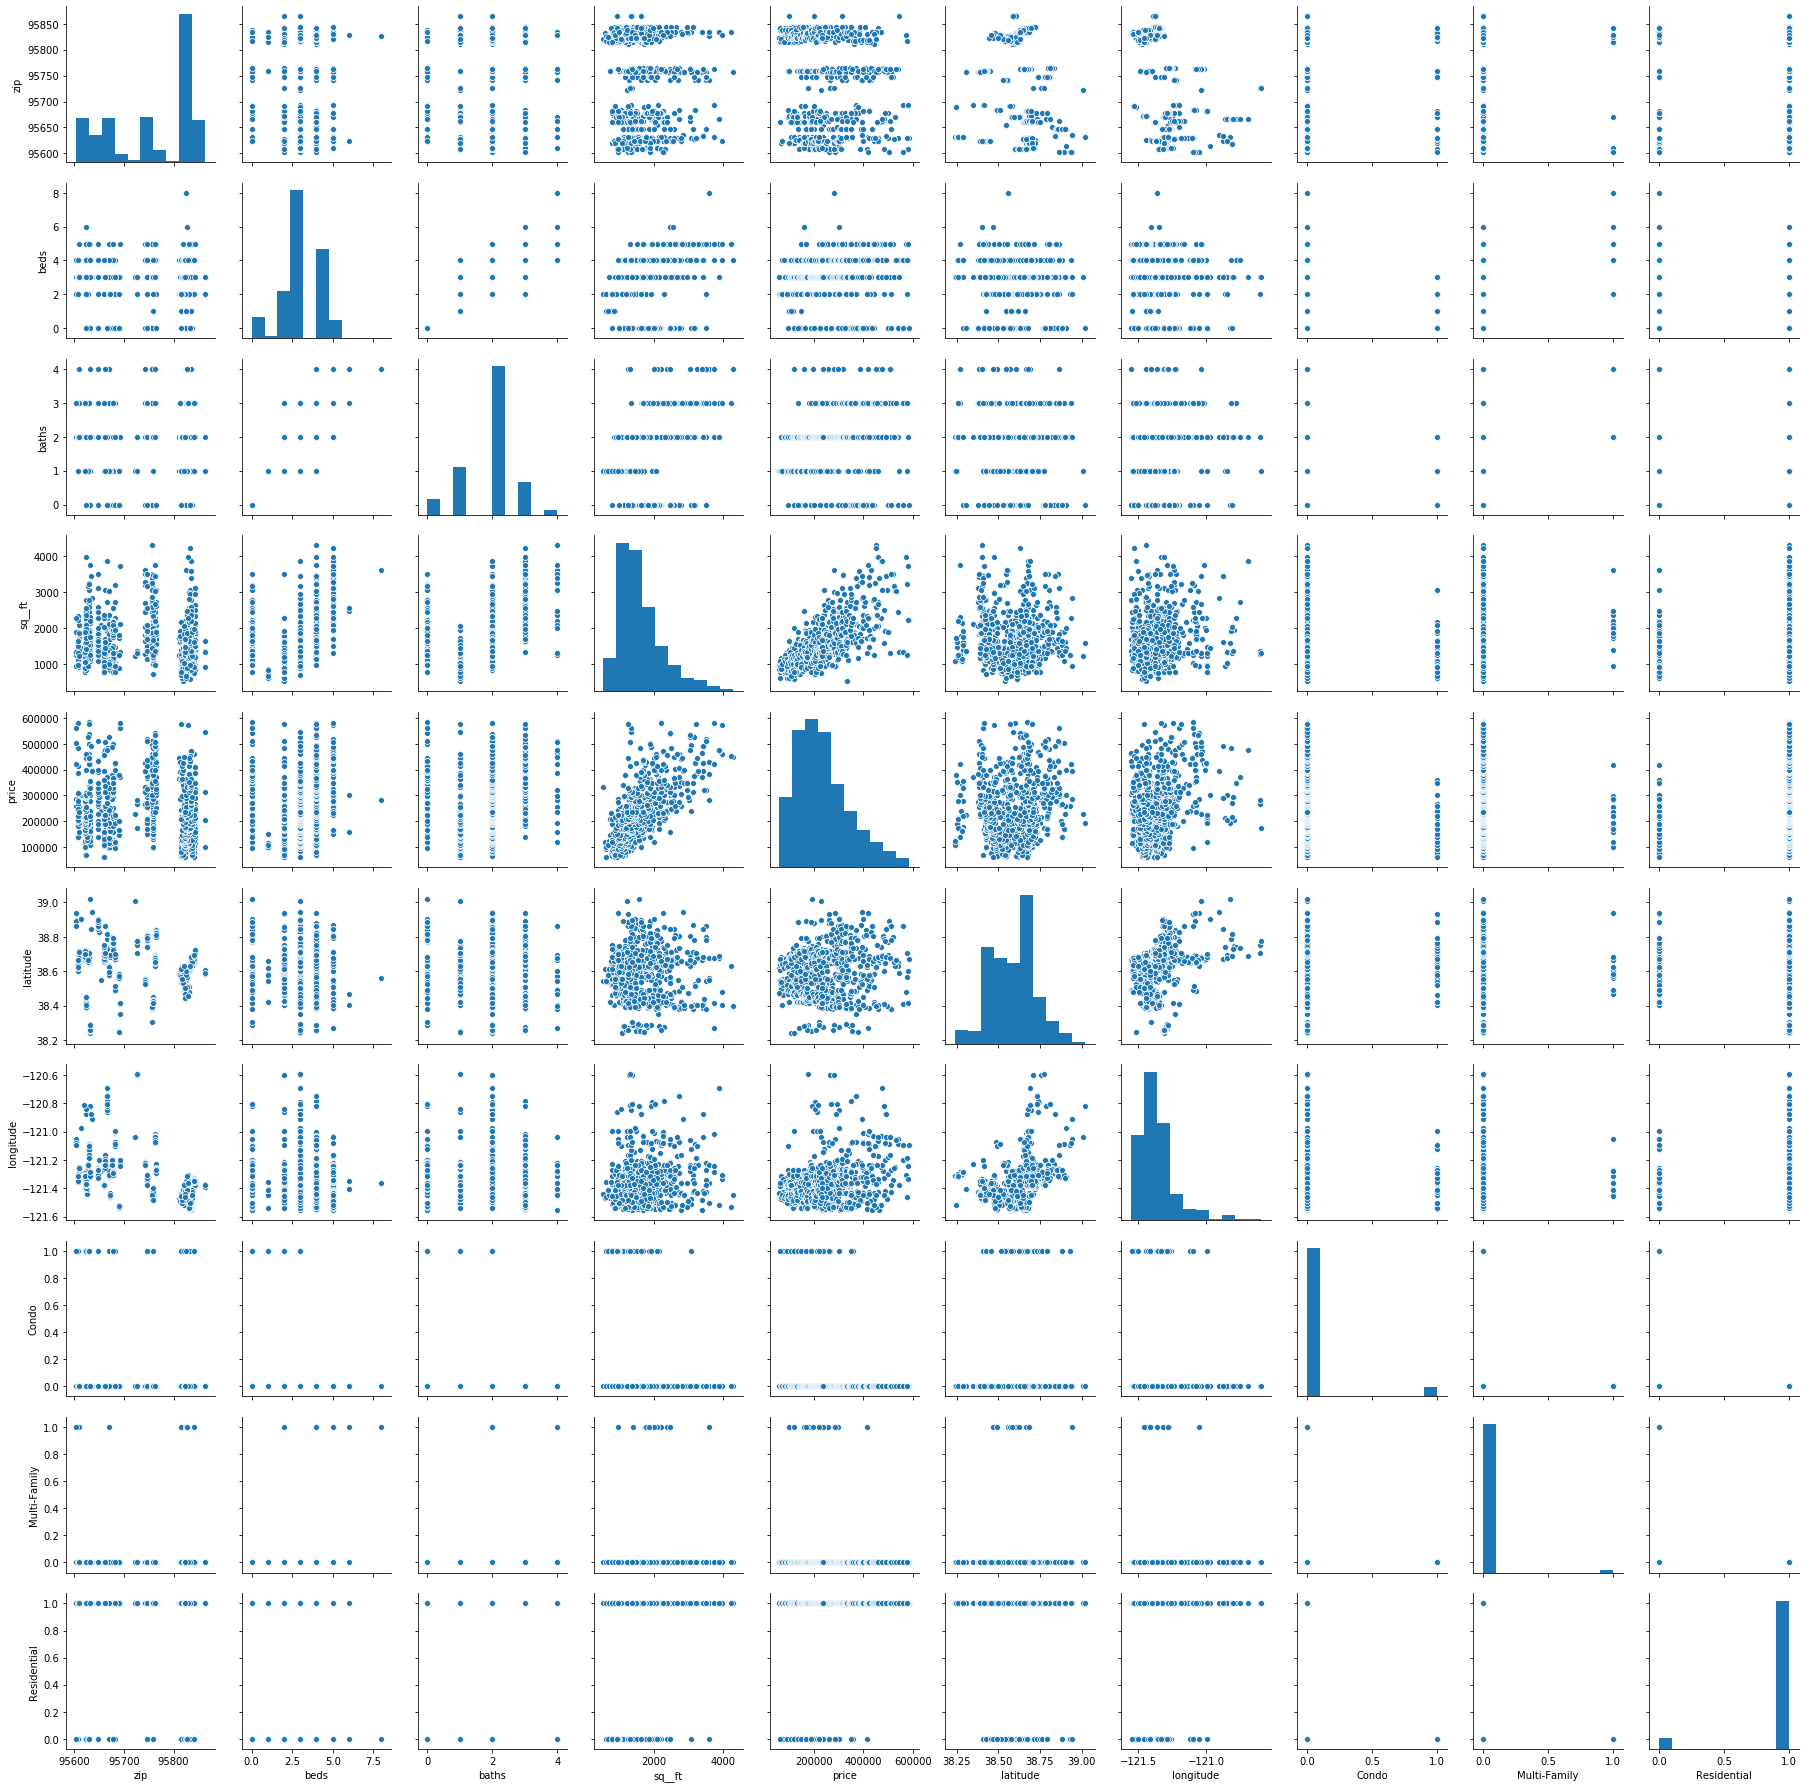

In [95]:
#Generate pairplot for visual summary of all relationships across features/target
sns.pairplot(sac);

### 3. Our goal will be to predict price. List variables that you think qualify as predictors of price in an SLR model. 

**For each of the variables you believe to be a valid potential predictor in an SLR model, generate a plot showing the relationship between the independent and dependent variables.**

In [96]:
#Print everything except our target column
sac.loc[:, sac.columns != 'price'].columns

Index(['street', 'city', 'zip', 'state', 'beds', 'baths', 'sq__ft', 'type',
       'sale_date', 'latitude', 'longitude', 'Condo', 'Multi-Family',
       'Residential'],
      dtype='object')

When you've finished cleaning or have made a good deal of progress cleaning, it's always a good idea to save your work.
```python
shd.to_csv('./datasets/sacramento_real_estate_transactions_Clean.csv')
```

In [97]:
#save clean file to csv
sac.to_csv('./datasets/clean_data.csv', index=False)

### 4. Which variable would be the best predictor of Y in an SLR model? Why?

The column "sq__ft" appear to have the most positive correlation with price based on our EDA above. This is not surprising given that the larger a house is, the more likely it is going to cost. There are some other discrete variables like bedrooms/bathrooms that one would expect to be also strong indicators, but their correlations to price are moderate in comparison. 

**However, the collinearity between bedrooms, bathrooms, and sq__ft is something that we need to keep in mind..**

### 5. Build a function that will take in two lists, `Y` and `X`, and return the intercept and slope coefficients that minimize SSE. 

`Y` is the target variable and `X` is the predictor variable.

- **Test your function on price and the variable you determined was the best predictor in Problem 4.**
- **Report the slope and intercept.**

In [98]:
from sklearn.linear_model import LinearRegression

#Build a function to instantiate LR object, fit to our data, and return slope and intercept
def slope_intercept(X,Y):
    model = LinearRegression()
    model.fit(X,Y)
    return(model.coef_,model.intercept_)
    
    

### 6. Interpret the intercept. Interpret the slope.

In [99]:
#Print out the desired values
slope_intercept(sac[['sq__ft']],sac[['price']])

(array([[120.50181034]]), array([42081.95731009]))

 - **Slope**: The price of a home without at square footage at all will be 22K. This is an odd intercept, because if we have sq__ft == 0 for a home, we do not have a home.

 - **Intercept**: For every incremental increase of 1 square foot for a home, it adds 131 dollar to the price.

### 7. Give an example of how this model could be used for prediction and how it could be used for inference. 

**Be sure to make it clear which example is associated with prediction and which is associated with inference.**

In the case of prediction, we could use this model to understand the price of a new home given it's square footage. In the case of inference, we can use this model to understand the relationship that exists between a home price and it's square footage.

### 8: [Bonus] Using the model you came up with in Problem 5, calculate and plot the residuals.

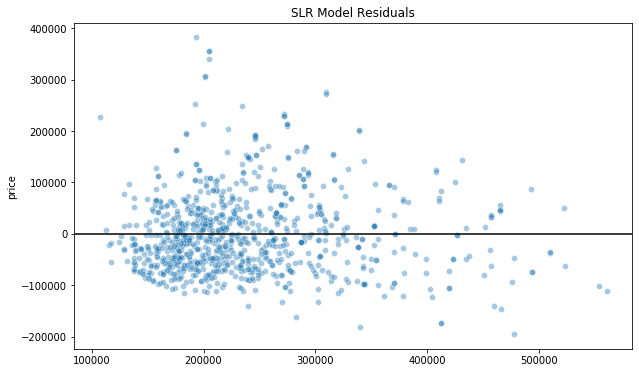

In [100]:
#Instantiate the model
model = LinearRegression()

X = sac[['sq__ft']]
y = sac['price']

model.fit(X,y)

#Store our yhat values
predictions = model.predict(X)

#Calculate the residuals
slr_residuals = y - predictions

#Plot 
plt.figure(figsize=(10,6))
sns.scatterplot(predictions, slr_residuals, alpha=0.4);
plt.title('SLR Model Residuals');
plt.axhline(0, color='black')


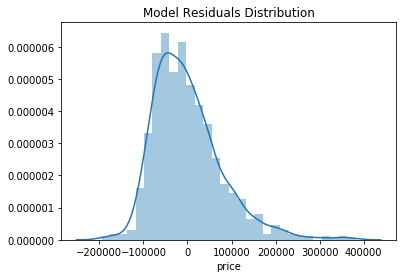

In [101]:
#Look at the distribution of residuals
sns.distplot(slr_residuals);
plt.title('Model Residuals Distribution');

In [102]:
#Define MSE function to use for accuracy
def MSE(true_col,pred_col):
    return((1/len(true_col)) * np.sum((true_col-pred_col)**2))

In [103]:
#Check accuracy of our model
MSE(y,predictions)

6126193707.01843

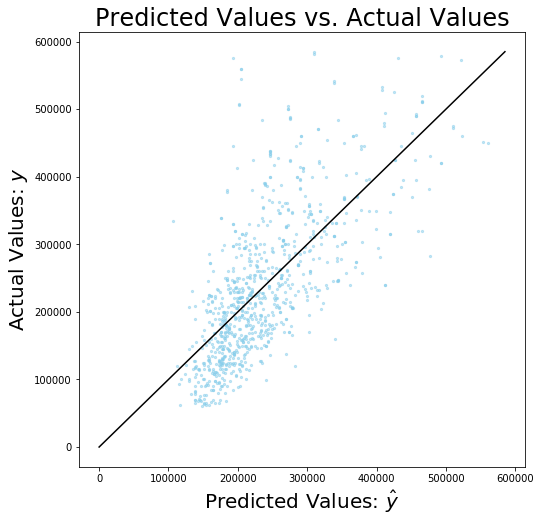

In [104]:
# Plot the model
plt.figure(figsize=(8,8))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(predictions, sac[['price']], s=5, color='skyblue', alpha = 0.5)

# Plot a line.
plt.plot([0, np.max(sac[['price']])],
         [0, np.max(sac[['price']])],
         color = 'black')

# Tweak title and axis labels.
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20)
plt.ylabel("Actual Values: $y$", fontsize = 20)
plt.title('Predicted Values vs. Actual Values', fontsize = 24);

---

> The material following this point can be completed after the second lesson on Monday.

---

## Dummy Variables

---

It is important to be cautious with categorical variables, which represent distict groups or categories, when building a regression. If put in a regression "as-is," categorical variables represented as integers will be treated like *continuous* variables.

That is to say, instead of group "3" having a different effect on the estimation than group "1" it will estimate literally 3 times more than group 1. 

For example, if occupation category "1" represents "analyst" and occupation category "3" represents "barista", and our target variable is salary, if we leave this as a column of integers then barista will always have `beta*3` the effect of analyst.

This will almost certainly force the beta coefficient to be something strange and incorrect. Instead, we can re-represent the categories as multiple "dummy coded" columns.

### 9. Use the `pd.get_dummies` function to convert the `type` column into dummy-coded variables.

Print out the header of the dummy-coded variable output.

In [105]:
sac_type_dummies = pd.get_dummies(sac['type'])
print(sac_type_dummies.head())

   Condo  Multi-Family  Residential
1      0             0            1
2      0             0            1
3      0             0            1
4      0             0            1
5      1             0            0


---

### A Word of Caution When Creating Dummies

Let's touch on precautions we should take when dummy coding.

**If you convert a qualitative variable to dummy variables, you want to turn a variable with N categories into N-1 variables.**

> **Scenario 1:** Suppose we're working with the variable "sex" or "gender" with values "M" and "F". 

You should include in your model only one variable for "sex = F" which takes on 1 if sex is female and 0 if sex is not female! Rather than saying "a one unit change in X," the coefficient associated with "sex = F" is interpreted as the average change in Y when sex = F relative to when sex = M.

| Female | Male | 
|-------|------|
| 0 | 1 | 
| 1 | 0 |
| 0 | 1 |
| 1 | 0 |
| 1 | 0 |
_As we can see a 1 in the female column indicates a 0 in the male column. And so, we have two columns stating the same information in different ways._

> Scenario 2: Suppose we're modeling revenue at a bar for each of the days of the week. We have a column with strings identifying which day of the week this observation occured in.

We might include six of the days as their own variables: "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday". **But not all 7 days.**  

|Monday | Tuesday | Wednesday | Thursday | Friday | Saturday | 
|-------|---------|-----------|----------|--------|----------|
| 1     | 0       |0          |      0   |0       | 0        | 
| 0     | 1       |0          |      0   |0       | 0        | 
| 0     | 0       |1          |      0   |0       | 0        | 
| 0     | 0       |0          |      1   |0       | 0        | 
| 0     | 0       |0          |      0   |1       | 0        | 
| 0     | 0       |0          |      0   |0       | 1        | 
| 0     | 0       |0          |      0   |0       | 0        | 

_As humans we can infer from the last row that if its is not Monday, Tusday, Wednesday, Thursday, Friday or Saturday than it must be Sunday. Models work the same way._

The coefficient for Monday is then interpreted as the average change in revenue when "day = Monday" relative to "day = Sunday." The coefficient for Tuesday is interpreted in the average change in revenue when "day = Tuesday" relative to "day = Sunday" and so on.

The category you leave out, which the other columns are *relative to* is often referred to as the **reference category**.

### 10. Remove "Unkown" from four dummy coded variable dataframe and append the rest to the original data.

In [106]:
len(sac_type_dummies), len(sac)

(897, 897)

In [107]:
sac_type_dummies.index, sac.index

(Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
             ...
             975, 976, 977, 978, 979, 980, 981, 982, 983, 984],
            dtype='int64', length=897),
 Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
             ...
             975, 976, 977, 978, 979, 980, 981, 982, 983, 984],
            dtype='int64', length=897))

In [108]:
sac = sac.merge(sac_type_dummies, 
                left_index=True, right_index=True)

### 11. Build what you think may be the best MLR model predicting `price`. 

The independent variables are your choice, but *include at least three variables.* At least one of which should be a dummy-coded variable (either one we created before or a new one).

To construct your model don't forget to load in the statsmodels api:

```python
from sklearn.linear_model import LinearRegression

model = LinearRegression()
```

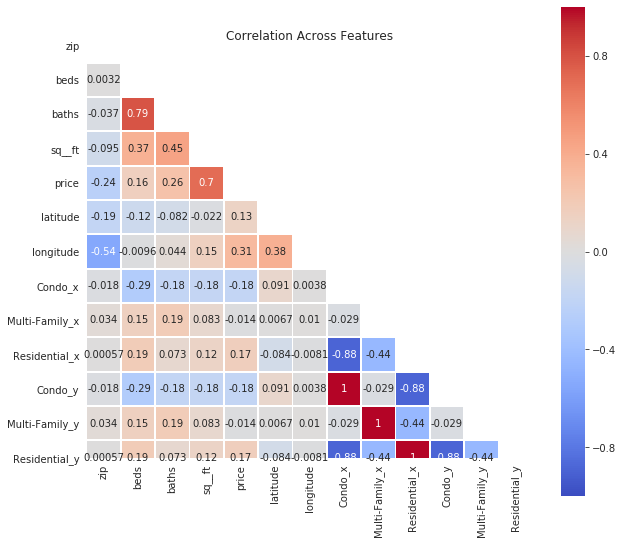

In [109]:
#Build figure space
plt.figure(figsize=(10,9))

#Generate correlations across our features
corr = sac.corr()

#Set up a white upper triangle to mask our repeating data
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Put it all together and use the coolwarm cmap
with sns.axes_style("white"):
    sns.heatmap(corr, mask=mask, square=True, annot=True, vmin=-1, vmax=1, linewidths=.9, cmap='coolwarm').set_title("Correlation Across Features")

In [110]:
#Instantiate model for MVLR
multimodel = LinearRegression()

#Define our features and target
X = sac[['sq__ft', 'longitude', 'Condo', 'Multi-Family', 'latitude', 'zip', 'beds',]]
y = sac[['price']]

#fit, and predict
multimodel.fit(X,y)
multipredictions = multimodel.predict(X)


KeyError: "['Condo', 'Multi-Family'] not in index"

### 12. Plot the true price vs the predicted price to evaluate your MLR visually.

In [ ]:
def MSE(true_col,pred_col):
    return((1/len(true_col)) * np.sum((true_col-pred_col)**2))

In [ ]:
MSE(sac[['price']],multipredictions)

In [ ]:
# Plot the model
plt.figure(figsize=(8,8))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(multipredictions, sac[['price']], s=5, color='skyblue', alpha = 0.5)

# Plot a line.
plt.plot([0, np.max(sac[['price']])],
         [0, np.max(sac[['price']])],
         color = 'black')

# Tweak title and axis labels.
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20)
plt.ylabel("Actual Values: $y$", fontsize = 20)
plt.title('Predicted Values vs. Actual Values', fontsize = 24);

In [ ]:
#Instantiate the model
model = LinearRegression()

X = sac[['sq__ft', 'longitude', 'Condo', 'Multi-Family', 'latitude', 'zip', 'beds', 'baths']]
y = sac['price']

model.fit(X,y)

#Store our yhat values
predictions = model.predict(X)

#Calculate the residuals
mlr_residuals = y - predictions

#Plot out new column
plt.figure(figsize=(10,6))
sns.scatterplot(predictions, mlr_residuals, alpha=0.4);
plt.title('MLR Residuals');
plt.axhline(0, color='black')


In [ ]:
#Plot MLR residual distribution
sns.distplot(mlr_residuals)
plt.title('MLR Residuals Distribution');
mlr_residuals.skew()

### 13. List the five assumptions for an MLR model. 

Indicate which ones are the same as the assumptions for an SLR model. 

**SLR AND MLR**:  

- *Linearity: Y must have an approximately linear relationship with each independent X_i.*
- *Independence: Errors (residuals) e_i and e_j must be independent of one another for any i != j.*
- *Normality: The errors (residuals) follow a Normal distribution.*
- *Equality of Variances: The errors (residuals) should have a roughly consistent pattern, regardless of the value of the X_i. (There should be no discernable relationship between X_1 and the residuals.)*

**MLR ONLY**:  
- *Independence Part 2: The independent variables X_i and X_j must be independent of one another for any i != j*





### 14. Pick at least two assumptions and articulate whether or not you believe them to be met  for your model and why.

 - **Normality** : Look at the residuals for our MLRs, it appears that there is a slight right skew, so this principle is violated. Using .skew() we can validate this.
 - **Equality of Variances**: It appears that as our values of X grow, the larger the residuals, so it appears this assumption is also violated.

### 15. [Bonus] Generate a table showing the point estimates, standard errors, t-scores, p-values, and 95% confidence intervals for the model you built. 

**Write a few sentences interpreting some of the output.**

> **Hint:** scikit-learn does not have this functionality built in, but statsmodels does in the `summary` method.  To fit the statsmodels model use something like the following.  There is one big caveat here, however!  `statsmodels.OLS` does _not_ add an intercept to your model, so you will need to do this explicitly by adding a column filled with the number 1 to your X matrix

```python
import statsmodels.api as sm

# The Default here is Linear Regression (ordinary least squares regression OLS)
model = sm.OLS(y,X).fit()
```

In [ ]:
import statsmodels.api as sm

#Add in intercept column
X['intercept'] = 1;

#OLS fit
sm_model = sm.OLS(y,X).fit();

In [ ]:
#Print summary statistics
sm_model.summary()

---

> The material following this point can be completed after the first lesson on Tuesday.

---

### 16. Regression Metrics

Implement a function called `r2_adj()` that will calculate $R^2_{adj}$ for a model. 

In [120]:
#Defining an equation for r2 Adjusted
def r2_adj(residuals, y, X):
    
    #Start by squaring and summing the residuals passed in
    rss = (residuals ** 2).sum()
    
    #Our null prediction is the mean of y in this case
    null_pred = y.mean()
    
    #Find the null residuals by subtracting null predictions from y
    null_residuals = y - null_pred
    
    #Find SS of null residuals by squaring and summing
    null_ss = (null_residuals**2).sum()
    
    #calculate r2    
    r_2 = 1 - rss / null_ss
    
    #length of y
    n = y.count()
    
    #number of features
    k = len(X.columns)
    
    #return r2
    return 1-(((1-r_2)*(n-1)) / (n-k-1))
    

### 17. Metrics, metrics, everywhere...

Write a function to calculate and print or return six regression metrics.  Use other functions liberally, including those found in `sklearn.metrics`.

In [129]:

def regression_metrics(y, y_hat, X):
    residuals = y-y_hat
    print(f"RSS: {np.sum((y-y_hat)**2)}")
    print(f"MSE: {mean_squared_error(y,y_hat)}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y,y_hat))}")
    print(f"r2: {r2_score(y,y_hat)}")
    print(f"r2 Adj: {r2_adj(residuals,y,X)}")
    print(f"MAE: {mean_absolute_error(y,y_hat)}")


### 18. Model Iteration

Evaluate your current home price prediction model by calculating all six regression metrics.  Now adjust your model (e.g. add or take away features) and see how to metrics change.

In [130]:
#Run current model through to check estimates
regression_metrics(y,predictions,X)

RSS: 5495195755195.531
MSE: 6126193707.01843
RMSE: 78270.00515534946
r2: 0.48795952046414615
r2 Adj: 0.4873874081965084
MAE: 59555.70615853745


In [136]:
#Pull out a number of features
X = sac[['sq__ft', 'longitude','latitude', 'zip']]
y = sac['price']
model.fit(X,y)
predictions = model.predict(X)


In [137]:
#Re-run
regression_metrics(y,predictions,X)

RSS: 4916716729834.67
MSE: 5481289553.884805
RMSE: 74035.73160227975
r2: 0.5418620001469048
r2 Adj: 0.53980756965429
MAE: 55567.26531962742


### 19. Bias vs. Variance

At this point, do you think your model is high bias, high variance or in the sweet spot?  If you are doing this after Wednesday, can you provide evidence to support your belief?

In [153]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.4)

In [154]:
cross_val_score(model, X_train,y_train, cv=5).mean()

0.535449506992703

In [155]:
cross_val_score(model, X_test,y_test, cv=5).mean()

0.508726510516939

Based on averages of our cross validation scores it appears that the accuracy of our model is relatively consistent between both the train and test sets. While our model is generally not demonstrating a strong R2 it does appear to produce consistently moderate R2 values. So this means that we are high bias but low variance.